# Tutorial

The following tutorial is intended to help familiarize you with initialization of a DelaySpectrum object and some of the options available for analysis.

## Initializing packages and files

In [1]:
# NBVAL_IGNORE_OUTPUT
%matplotlib inline

In [2]:
# NBVAL_IGNORE_OUTPUT
import os
from matplotlib.pyplot import *
import numpy as np
from astropy import units, constants as const

from pyuvdata import UVData, UVBeam
from simpleDS import DelaySpectrum, cosmo as simple_cosmo, utils
from simpleDS.data import DATA_PATH
from pyuvdata.data import DATA_PATH as UVDATA_PATH

The following imports are helpful utilities for plotting, especially `quantity_support` which makes plotting quantities much easier.

In [3]:
# NBVAL_IGNORE_OUTPUT
from matplotlib.colors import LogNorm, SymLogNorm

from astropy.visualization import quantity_support
quantity_support();

The data file being loaded is part of the `pyuvdata` test data and the beam file is included with this package.

In [4]:
data_file = os.path.join(UVDATA_PATH, 'test_redundant_array.uvfits')
beam_file = os.path.join(DATA_PATH, 'test_redundant_array.beamfits')

## Load Data

First a UVData object must be used to read in data

In [5]:
uvd = UVData()
uvd.read_uvfits(data_file)

It would normally be necessary to also down-select to only one set of redundant baselines but this PAPER data is already in that format.

For other data sets this can be accomplised with the `UVData.get_redundancies()` method to identify redundant baseline groups.

## Load Beam Information

In [6]:
uvb = UVBeam()
uvb.read_beamfits(beam_file)

## Initialize the DelaySpectrum Object

DelaySpectrum objects rely on three main pieces of data for power spectrum estimation.

- uv: Input UVData object or list of two UVData objects to cross multiply
- uvb: Input UVBeam object
- trcvr: Quantity in units of K of single receiver temperature or a (Nspws, Nfreqs) array of receiver temperature

All three of these can be provided to the object during initialization or by calling functions on a blank object.

### Add data at initialization 

In [7]:
ds = DelaySpectrum(uv=uvd, uvb=uvb, trcvr=144 * units.K)

### Or add data manually

In [8]:
ds = DelaySpectrum()
ds.add_uvdata(uvd)
ds.add_uvbeam(uvb)
ds.add_trcvr(144 * units.K)

### Adding multiple UVData objects

To cross multiply data in two uvdata objects provide the keyword `uv` with a list of two uvdata objects, or manually call `add_uvdata` with each UVData object

In [9]:
ds = DelaySpectrum()
# Calling these lines of code is a little redundant 
# since we already multiply a single object by itself.
# It does however help illustrate how to initialize two UVData objects
ds.add_uvdata(uvd)
ds.add_uvdata(uvd)

ds.add_uvbeam(uvb)
ds.add_trcvr(144 * units.K)

## Spectral Window Selection

The `select_spectral_windows` function allows us to 
downselect to only a subset of the data and perform the Fourier Transform.

The inputs for this functions should be one of the following:
    - A tuple with indices (start_channel, end_channel)
    - A list of tuples [(start_1, end_1), (start_2, end_2)....(start_n, end_n)]
    - A 1-D array of frequencies to select
    - A 2-D array of frequencies for multiple spectral windows

For all formats, all spectral windows must be the same length (`Nfreqs`)

### Single tuple selection

The following will downselect to one spectral window with 13 frequencies and return a new DelaySpectrum object.

In [10]:
ds_selected = ds.select_spectral_windows([0,12], inplace=False)

### List of tuple selection

The following will downselect to one spectral window with two 13 frequencies and return a new DelaySpectrum object.

In [11]:
ds_selected = ds.select_spectral_windows([(0,12), (7, 19)], inplace=False)

### Selection with frequencies

A selection can also be done by passing the frequencies themselves and calling the `freqs` keyword

In [12]:
new_freqs = units.Quantity([ds.freq_array[0,0:10], ds.freq_array[0,10:20]])
ds_selected = ds.select_spectral_windows(freqs=new_freqs, inplace=False)

## Noise Generation, Optional

SimpleDS provides a built in generator for complex random noise.
It is designed to help validate the overal normalization of the Fourier Transform and provide a estimate of thermal noise uncertainties.

Currently, the built in noise generator needs to get triggered manually to generate accurately given the input data and beam.
It is a WIP but if you want a noise simulation along with your input make sure to call this function

In [13]:
ds.generate_noise()

## Power Spectrum Estimation

Power spectrum estimation with simpleDS can be performed in one step by calling the function `calculate_delay_spetrum`.
This automatically does the following

    - Delay transforms the data by calling ds.delay_transform()
    - Cross multiply redundant baselines 
    - Estimate the thermal noise uncertainty 
    - Convert from Jy^2 Hz^2 units to mK^2 Mpc^3
    
The `delay_transform()` function can be called independently to investigate the data in delay space without power spectrum estimation.
By default the DelaySpectrum object assumed a Planck 15 Year cosmology.

In python 3, an extra boolean `littleh_units` exits. Setting this to `True` has astropy convert to mK^2 Mpc^3 / littleh^3 units.

In [14]:
ds.calculate_delay_spectrum(littleh_units=True)

The output `power_array` variable can be daunting to index at first. Currently there are no helper functions for indexing this array.
The array is documented in the [paramters docs](https://simpleds.readthedocs.io/en/latest/dspec_parameters.html) also.

The array is stored as a (`Nspws`, `Npols`, `Nbls`, `Nbls`, `Ntimes`, `Nfreqs`) array.

## Some Example Plots

### Correlation matrix
 
A cross-correlation matrix can be plotted as a function of delay/k-mode and time. These can be useful to identify baseline which may exhibit too much or little correlation with other redundant baselines.

For this example we'll select the 0th polarization, 0th spectral window and 0th time. This selection is arbitrary but helps illustrate how a plot like this can be made.

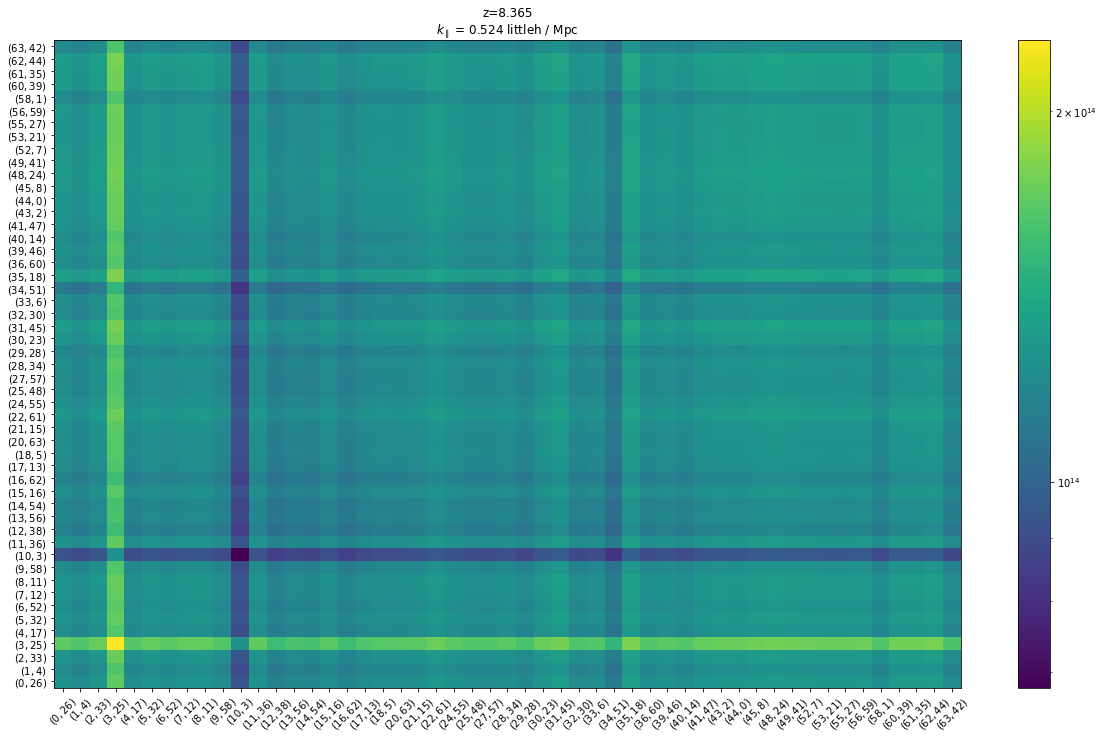

In [15]:
fig, ax = subplots(1, figsize=(17.5, 10))


im = ax.pcolormesh(np.abs(ds.power_array[(ds.Nspws-1)//2, 0, :, :, 0, (ds.Ndelays-1)//2]).value, norm=LogNorm()) 
fig.colorbar(im, ax=ax)

center_ticks = np.arange(ds.Nbls)+.5
ax.set_xticks(center_ticks)
bl_str = ['$({0},{1})$'.format(*uvd.baseline_to_antnums(bl)) for bl in ds.baseline_array ]
ax.set_xticklabels(bl_str, rotation=45);
ax.set_title("z={0:.3f}\n$k_{{\parallel}}$ = {1:.3f}".format(ds.redshift[(ds.Nspws-1)//2], ds.k_parallel[(ds.Nspws-1)//2, ds.Nfreqs-1]))
# ax.set_title("$k_{{\parallel}}$")

ax.set_yticks(center_ticks)
ax.set_yticklabels(bl_str);
fig.subplots_adjust(bottom=.05, top=.95, left=.05, right=.95)


### Power Waterfall

Plotting a waterfall (amplitude versus time and delay) of the power can also be useful to identify any features which may depend on time for a specific baseline.

For this example, we will arbitrarily select the 27th and 28th baselines from `ds.baseline_array` to plot.

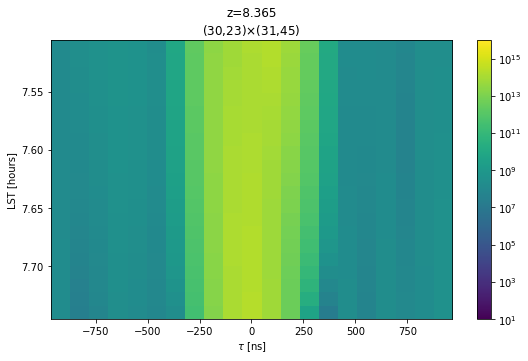

In [16]:
fig, ax = subplots(1, figsize=(9, 5))
norm=LogNorm(vmin=1e1, vmax=1e16)

# Convert the lst_array to hours for easier reading
lsts = ds.lst_array*12./np.pi * units.h

bl1, bl2 = ds.baseline_array[27], ds.baseline_array[28]
ants1 = uvd.baseline_to_antnums(bl1)
ants2 = uvd.baseline_to_antnums(bl2)

im = ax.pcolorfast(ds.delay_array.to('ns'), lsts, np.abs(ds.power_array[(ds.Nspws-1)//2, 0, 27, 28, :, :]).value, norm=norm)

fig.colorbar(im, ax=ax)

ax.set_title("z={0:.3f}\n({1},{2})$\\times$({3},{4})".format(ds.redshift[(ds.Nspws-1)//2], ants1[0], ants1[1], ants2[0], ants2[1]))
y_lim = [np.max(ax.get_ylim()), np.min(ax.get_ylim())]
ax.set_ylim(y_lim)
ax.set_xlabel("$\\tau$ [ns]")
ax.set_ylabel("LST [hours]")
fig.subplots_adjust(top=.9)

### One Dimensional Power Spectrum

The following example shows how to plot **all baseline cross multiples** for all times on a 1-Dimensional plot. These can take time to generate all the lines but can be useful to see the variance in the power spectrum estimates by eye. We'll also plot the average `thermal_power` calculated by the object and average absolute value of the complex noise generated earlier.

The reshape calls in these plots are used to create a 2-Dimensional array for matplotlib to iterate over.

The `noise_power` array needs to be handled a little differently if we want to know whether or not it is accurately predicted by the `thermal_noise` estimate.

A more accurate estimate is to find the mean value (hopefully 0) and the variance around this value. We'll use the `utils` module to perform a `remove_auto_correlations` which removes the diagonal from the Nbls, Nbls dimension of our power matrix. This is necessary since this example is cross-multiplying a single data set by itself and as a result the diagonal will not be zero-meaned but have a noise bias.

The estimate the mean, just take the mean over the 0th axis of the output of `remove_auto_correlations`. Estimating the variance requires using `utils.bootstrap_array` to bootstrap resample the noise power values. Errorbars are estimated by taking the mean value of each bootstrap, then computing the variance over all bootstraps.

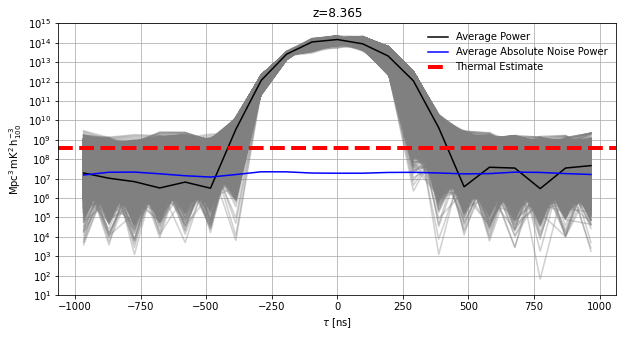

In [18]:
fig, ax = subplots(ncols=ds.Nspws, figsize=(10,5), squeeze=False, sharey=True)

for cnt, _ax in enumerate(ax[0]):

    noise_power = utils.remove_auto_correlations(ds.noise_power[cnt, 0])
    noise_val = noise_power.mean(0)
    
    noise_boot = utils.bootstrap_array(noise_power)
    noise_err = noise_boot.mean(0).real.std(0) + 1j * noise_boot.mean(0).imag.std(0)
    
    # noise_val and noise_err should now be a (Ntimes, Ndelays)
    # for this example we'll take the mean over time of this noise + err value to plot
    
    _ax.set_title("z={0:.3f}".format(ds.redshift[cnt]))
    _ax.plot(ds.delay_array, np.abs(ds.power_array[cnt,:,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,ds.Ndelays).T.real), '', 
             linestyle='-',color='grey', alpha=.2, mfc='none')
    _ax.plot(ds.delay_array, np.abs(ds.power_array[cnt,:,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,ds.Ndelays).mean(0).real), '',
             linestyle='-',color='black', mfc='none', label='Average Power')
    _ax.plot(ds.delay_array, np.abs( (noise_val + noise_err).real).mean(0), '',
             linestyle='-',color='blue', mfc='none', label='Average Absolute Noise Power')
    _ax.axhline( ds.thermal_power[cnt,0,:,:,:].reshape(ds.Nbls*ds.Nbls*ds.Ntimes,1).mean(0).real, linestyle='--',
                color='red', linewidth=4, label='Thermal Estimate')
    
    _ax.grid()
    _ax.set_yscale('log')
    _ax.set_xlabel("$\\tau$ [ns]")

y_lim = ax[0][0].get_ylim()
y_ticklabels = ["10^{0:d}".format(x) for x in np.arange(np.log10(y_lim[0]), np.log10(y_lim[1])+1, dtype=np.int32)]
y_ticks = [10**x for x in np.arange(np.log10(y_lim[0]), np.log10(y_lim[1])+1, dtype=np.int32)]
ax[0][0].set_yticks(y_ticks);
ax[0][0].legend(frameon=False, loc='best');